In [53]:
# Loading packages and data needed.
library(tidyr)
library(dplyr)
library(readr)
library(ggplot2)
library(cluster)
library(factoextra)

degrees = read_csv('datasets/degrees-that-pay-back.csv', col_names=c('College.Major',
                    'Starting.Median.Salary','Mid.Career.Median.Salary','Career.Percent.Growth',
                    'Percentile.10','Percentile.25','Percentile.75','Percentile.90'), skip=1)

# Taking a quick look at the data.
head(degrees)
summary(degrees)

Parsed with column specification:
cols(
  College.Major = col_character(),
  Starting.Median.Salary = col_character(),
  Mid.Career.Median.Salary = col_character(),
  Career.Percent.Growth = col_double(),
  Percentile.10 = col_character(),
  Percentile.25 = col_character(),
  Percentile.75 = col_character(),
  Percentile.90 = col_character()
)


College.Major,Starting.Median.Salary,Mid.Career.Median.Salary,Career.Percent.Growth,Percentile.10,Percentile.25,Percentile.75,Percentile.90
Accounting,"$46,000.00","$77,100.00",67.6,"$42,200.00","$56,100.00","$108,000.00","$152,000.00"
Aerospace Engineering,"$57,700.00","$101,000.00",75.0,"$64,300.00","$82,100.00","$127,000.00","$161,000.00"
Agriculture,"$42,600.00","$71,900.00",68.8,"$36,300.00","$52,100.00","$96,300.00","$150,000.00"
Anthropology,"$36,800.00","$61,500.00",67.1,"$33,800.00","$45,500.00","$89,300.00","$138,000.00"
Architecture,"$41,600.00","$76,800.00",84.6,"$50,600.00","$62,200.00","$97,000.00","$136,000.00"
Art History,"$35,800.00","$64,900.00",81.3,"$28,800.00","$42,200.00","$87,400.00","$125,000.00"


 College.Major      Starting.Median.Salary Mid.Career.Median.Salary
 Length:50          Length:50              Length:50               
 Class :character   Class :character       Class :character        
 Mode  :character   Mode  :character       Mode  :character        
                                                                   
                                                                   
                                                                   
 Career.Percent.Growth Percentile.10      Percentile.25      Percentile.75     
 Min.   : 23.40        Length:50          Length:50          Length:50         
 1st Qu.: 59.12        Class :character   Class :character   Class :character  
 Median : 67.80        Mode  :character   Mode  :character   Mode  :character  
 Mean   : 69.27                                                                
 3rd Qu.: 82.42                                                                
 Max.   :103.50                             

In [55]:
# Removing dollar signs ($) from all columns except College.Major and adding a column for career percent growth.
degrees_clean = degrees %>% 
    mutate_at(vars(Starting.Median.Salary:Percentile.90), 
              function(x) as.numeric(gsub("[\\$,]","",x))) %>%
    mutate(Career.Percent.Growth = Career.Percent.Growth/100)

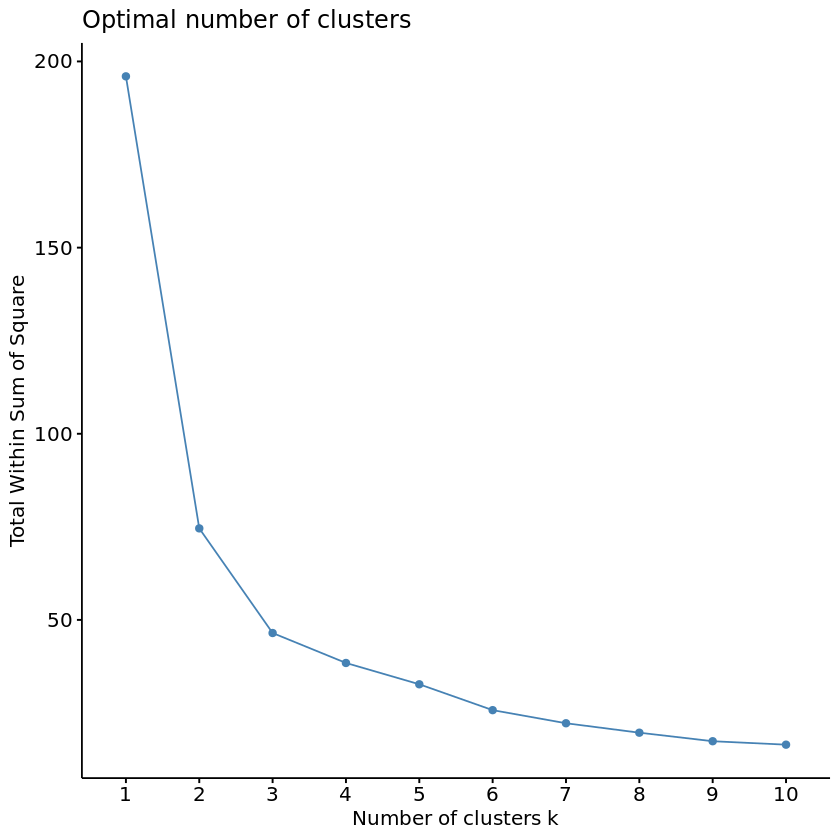

In [57]:
# Selecting and scaling relevant columns for the k-means algorithm.
k_means_data = degrees_clean %>%
    select(Starting.Median.Salary, Mid.Career.Median.Salary, 
           Percentile.10, Percentile.90) %>%
    scale()

# Applying the Elbow Method.
elbow_method = fviz_nbclust(k_means_data, kmeans, method = "wss")
elbow_method

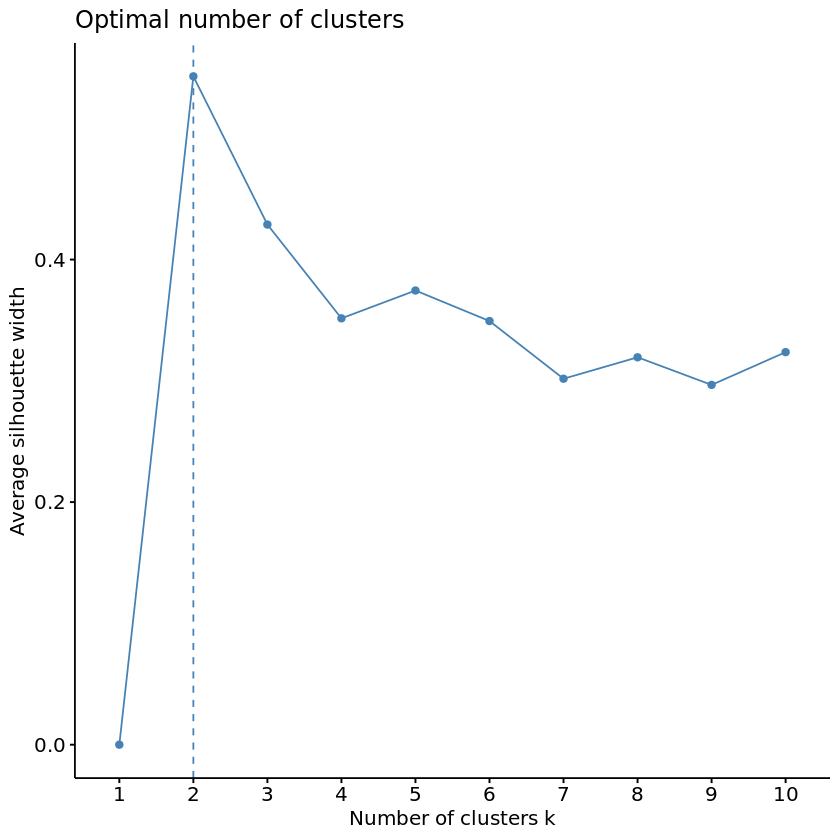

In [59]:
# Applying the Silhouette Method.
silhouette_method = fviz_nbclust(k_means_data, kmeans, method = "silhouette")
silhouette_method

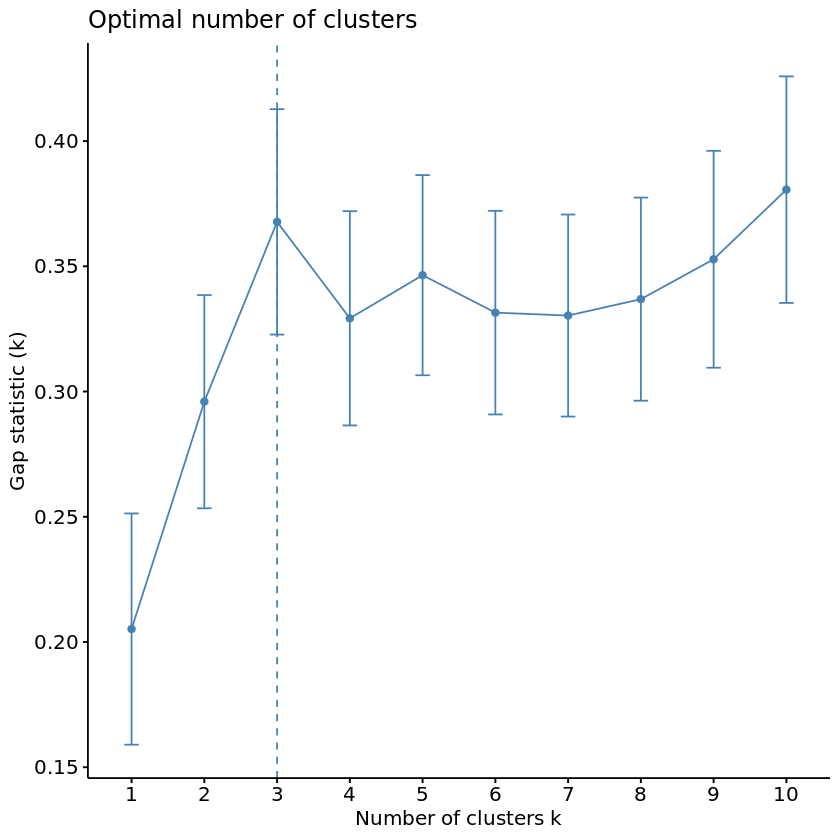

In [61]:
# Applying the Gap Statistic Method.
gap_stat = clusGap(k_means_data, FUN = kmeans, nstart = 25, K.max = 10, B = 50)
gap_stat_method <- fviz_gap_stat(gap_stat)
gap_stat_method

In [63]:
set.seed(111)

# Setting k equal to the optimal number of clusters.
num_clusters = 3

# Running the k-means algorithm.
k_means = kmeans(k_means_data, num_clusters, iter.max = 15, nstart = 25)

# Adding the cluster labels to the data.
degrees_labeled = degrees_clean %>%
    mutate(clusters = k_means$cluster)

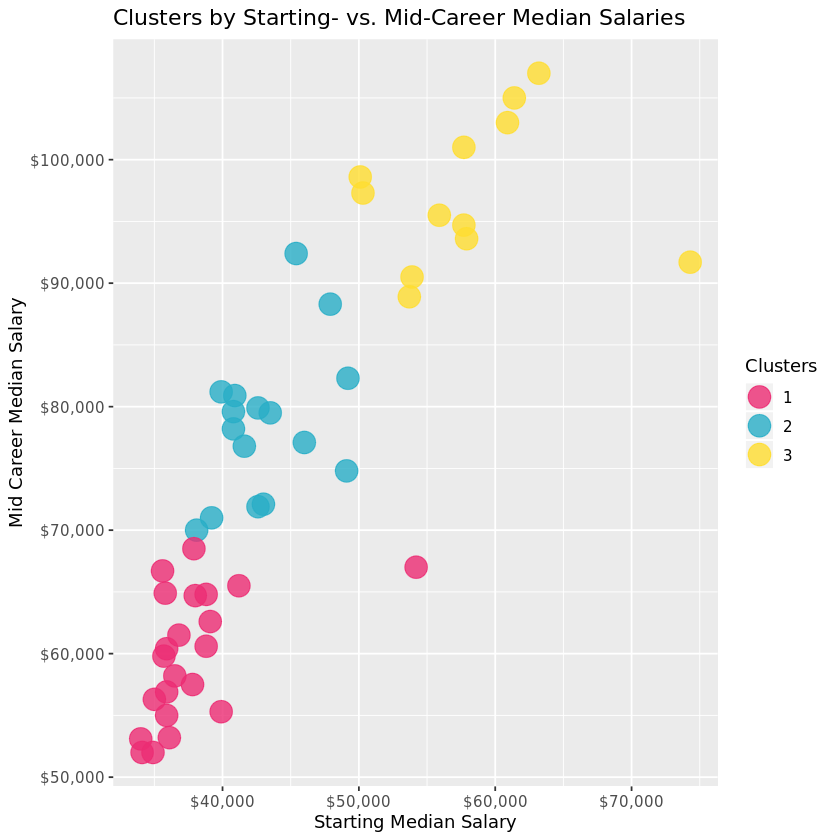

In [65]:
# Graphing the clusters by Starting- and Mid-Career Median salaries.
career_growth = ggplot(degrees_labeled, aes(x=Starting.Median.Salary,y=Mid.Career.Median.Salary,
    color=factor(clusters))) +
    geom_point(alpha=4/5,size=6) +
    scale_x_continuous(labels = scales::dollar) +
    scale_y_continuous(labels = scales::dollar) +
    xlab('Starting Median Salary') +
    ylab('Mid Career Median Salary') +
    scale_color_manual(name="Clusters",values=c("#EC2C73","#29AEC7", 
                    "#FFDD30")) +
    ggtitle('Clusters by Starting- vs. Mid-Career Median Salaries')
career_growth

In [67]:
# Reshaping the data and reordering the new percentile column.
degrees_perc = degrees_labeled %>%
    select(College.Major, Percentile.10, Percentile.25, 
           Mid.Career.Median.Salary, Percentile.75, 
           Percentile.90, clusters) %>%
    gather(key=percentile, value=salary, -c(College.Major, clusters)) %>%
    mutate(percentile=factor(percentile,levels=c('Percentile.10','Percentile.25',
            'Mid.Career.Median.Salary','Percentile.75','Percentile.90')))

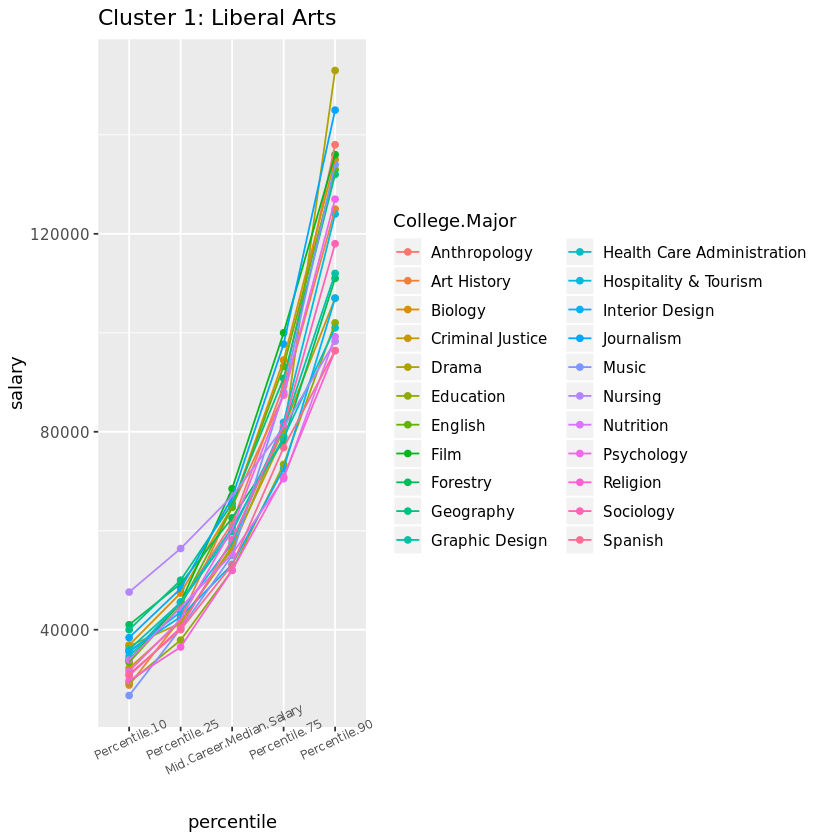

In [69]:
# Graphing the majors of Cluster 1 by percentile.
cluster_1 = ggplot(degrees_perc[degrees_perc$clusters==1,], 
                    aes(x=percentile,y=salary, 
                    group=College.Major, color=College.Major, order=salary)) +
                    geom_point() +
                    geom_line() +
                    ggtitle('Cluster 1: Liberal Arts') +
                    theme(axis.text.x = element_text(size=7, angle=25))
cluster_1

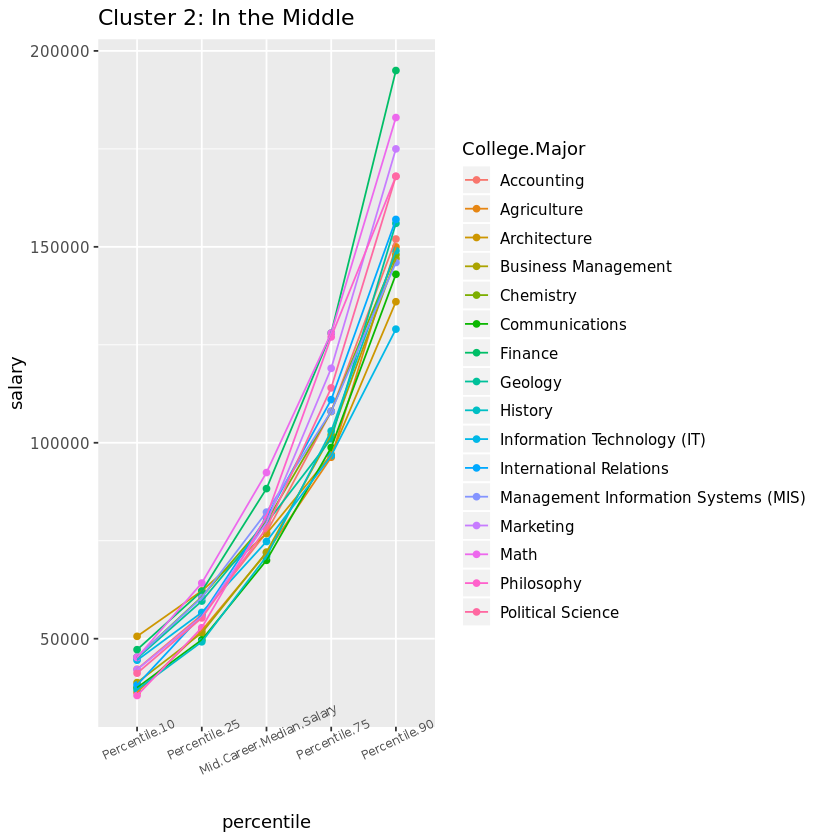

In [71]:
# Graphing the majors of Cluster 2 by percentile.
cluster_2 = ggplot(degrees_perc[degrees_perc$clusters==2,], 
    aes(x=percentile,y=salary, 
    group=College.Major, color=College.Major)) +
    geom_point() +
    geom_line() +
    ggtitle('Cluster 2: In the Middle') +
    theme(axis.text.x = element_text(size=7, angle=25))
cluster_2

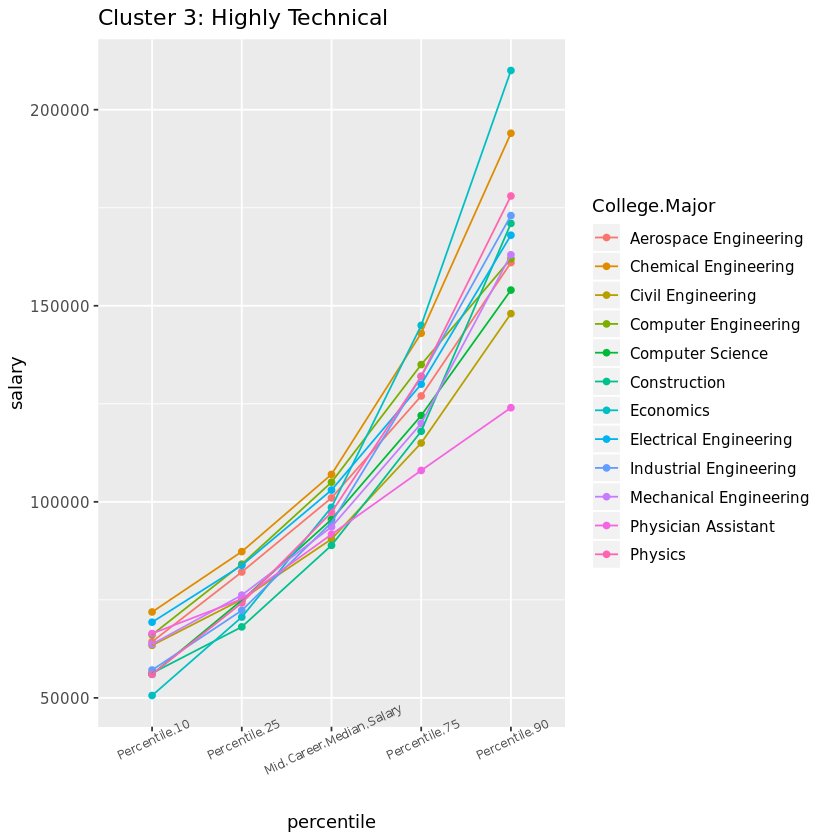

In [73]:
# Graphing the majors of Cluster 3 by percentile.
cluster_3 = ggplot(degrees_perc[degrees_perc$clusters==3,], 
    aes(x=percentile,y=salary, 
    group=College.Major, color=College.Major)) +
    geom_point() +
    geom_line() +
    ggtitle('Cluster 3: Highly Technical') +
    theme(axis.text.x = element_text(size=7, angle=25))
cluster_3

In [75]:
# Sorting degrees by career percent growth, and identifying the top 3 majors tied for highest career growth potential.
degrees_labeled = arrange(degrees_labeled, desc(Career.Percent.Growth))
degrees_labeled[1:3, ]

College.Major,Starting.Median.Salary,Mid.Career.Median.Salary,Career.Percent.Growth,Percentile.10,Percentile.25,Percentile.75,Percentile.90,clusters
Math,45400,92400,1.035,45200,64200,128000,183000,2
Philosophy,39900,81200,1.035,35500,52800,127000,168000,2
International Relations,40900,80900,0.978,38200,56000,111000,157000,2
